<a href="https://colab.research.google.com/github/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction/blob/master/Cine_Cardiac_MRI_Motion_Artifact_Reduction_Using_a_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [1]:
!git clone https://github.com/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction.git

Cloning into 'Cine-Cardiac-MRI-Motion-Artefact-Reduction'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 2), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.display import clear_output

In [4]:
!pip install medpy
clear_output()

In [6]:
%cd /content/Cine-Cardiac-MRI-Motion-Artefact-Reduction
import torch
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('darkgrid')
from seaborn.matrix import clustermap
import h5py
from matplotlib.patches import Rectangle
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms, datasets
from torchvision.transforms.transforms import ToTensor
from matplotlib.animation import FuncAnimation
from IPython import display

from utils.metrics_acdc import load_nii
from datasets.cine_dataset import read_h5py

/content/Cine-Cardiac-MRI-Motion-Artefact-Reduction


#Load and Visualize Data

In [ ]:
img_data_4d, affine_4d, header_4d = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz")
print(img_data_4d.shape, affine_4d.shape)

(240, 256, 10, 30) (4, 4)


In [ ]:
def interactive_gif(img, cmap = 'jet'):
  
  def Animate(slice):
    Figure = plt.figure() 
    # creating a plot
    # imgs_plotted = plt.imshow(img[:,:,0,slice], cmap = 'gray') 
    imgs_plotted = plt.imshow(img[:,:,slice,0], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
    
        # setting y according to frame
        # number and + x. It's logic
        # y = img[:,:,frame,slice]
        y = img[:,:,slice,frame]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    # anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[2]-1, interval=200)
    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[-1]-1, interval=100)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
  
  # good practice to close the plt object.
    plt.close()

  # select_slice = IntSlider(min=0, max=img.shape[-1]-1, description='Select Phase', continuous_update=True)
  select_slice = IntSlider(min=0, max=img.shape[2]-1, description='Select slice', continuous_update=True)

  # select_phase = IntSlider(min=0, max=frame.shape[3]-1, description='Select Phase', continuous_update=True)

  return interactive(Animate, slice=select_slice)#, phase = select_phase)
interactive_gif(img_data_4d, cmap = 'gray')

interactive(children=(IntSlider(value=0, description='Select slice', max=9), Output()), _dom_classes=('widget-…

# Data Analysis

In [ ]:
data_list = glob("/content/drive/MyDrive/Cine Cardiac/training/patient*/patient*_4d.nii.gz")
print(data_list)
phase_list = []
slice_list = []
ignore = ["/content/drive/MyDrive/Cine Cardiac/training/patient009/patient009_4d.nii.gz",]

for i in data_list:
  if i in ignore:
    phase_list.append(0)
    slice_list.append(0)
    continue
  img_data_4d, affine_4d, header_4d = load_nii(i)
  phase_list.append(img_data_4d.shape[-1])
  slice_list.append(img_data_4d.shape[-2])


print(phase_list)
print(slice_list)


['/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient002/patient002_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient003/patient003_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient004/patient004_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient005/patient005_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient006/patient006_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient007/patient007_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient008/patient008_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient009/patient009_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient010/patient010_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient011/patient011_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient012/patient012_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/tr

In [ ]:
#select scans with 30 phase
select_list = []
for i in range (len(phase_list)):
  if phase_list[i] == 30:
    select_list.append(data_list[i])
print(select_list)
print(len(select_list))

['/content/drive/MyDrive/Cine Cardiac/training/patient001/patient001_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient002/patient002_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient003/patient003_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient005/patient005_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient012/patient012_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient013/patient013_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient014/patient014_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient016/patient016_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient019/patient019_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient027/patient027_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/training/patient029/patient029_4d.nii.gz', '/content/drive/MyDrive/Cine Cardiac/tr

In [ ]:
## Separate into train and val
train_list = select_list[:-7]
val_list = select_list[-7:]
print(len(train_list), len(val_list))

37 7


### Create Training Data

In [ ]:
#Create Train Data
img_no = 36
index =  [110,120] #26 [60,130] #22 [80,160]  #18[80,60]  #11, 19, 24 [80,140]    #10 [80,120]   
#7,20,21,23, 27 [90,130]   #3,6,17,25,28 [120,100]     #0-2, 4-5, 8- 10, 12-16, [100,130] 
print(train_list[img_no])
img_data_4d, affine_4d, header_4d = load_nii(train_list[img_no])
print(img_data_4d.shape)
save_path = "/content/drive/MyDrive/Cine Cardiac/train_data/"

for slice_no in range(img_data_4d.shape[-2]): 
  img_frames = img_data_4d[index[0]-50:index[0]+50,index[1]-50:index[1]+50,slice_no,:]
  print(img_frames.shape,img_frames.min(),img_frames.max())

  
  plt.figure()
  plt.imshow(img_data_4d[:,:,slice_no,14],cmap='gray')
  # plt.gca().add_patch(Rectangle((index[0]-50,index[1]-50),100,100,linewidth=1,edgecolor='r',facecolor='none'))
  plt.axis('off')
  plt.show()

  plt.figure()
  plt.imshow(img_frames[:,:,14],cmap='gray')
  plt.axis('off')
  plt.show()

  hf = h5py.File(save_path+f'train_{train_list[img_no][-13:-10]}_slice_{slice_no}.h5', 'w')
  hf.create_dataset('train', data = img_frames)
  hf.close()


In [ ]:
h5_file = "/content/drive/MyDrive/Cine Cardiac/train_data/train_076_slice_1.h5"

img_test = read_h5py(h5_file)
print(len(img_test))
img_test = np.reshape(img_test,(100,100,1,30))
interactive_gif(img_test, cmap = 'gray')

Reading from /content/drive/MyDrive/Cine Cardiac/train_data/train_076_slice_1.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['train']>
Number of samples : 100
Shape of each data : (100, 100, 30)
100


interactive(children=(IntSlider(value=0, description='Select slice', max=0), Output()), _dom_classes=('widget-…

### Create Validation Data

/content/drive/MyDrive/Cine Cardiac/training/patient097/patient097_4d.nii.gz
(216, 256, 8, 30)
(100, 100, 30) 30.0 255.0


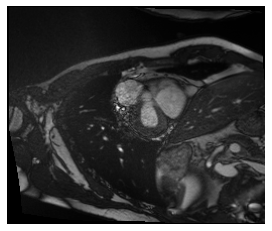

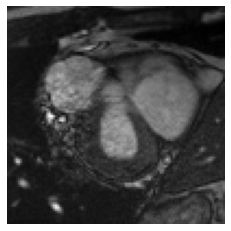

(100, 100, 30) 30.0 255.0


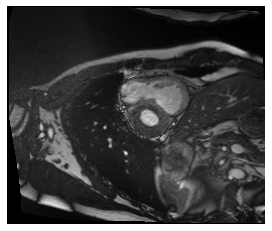

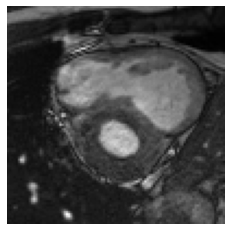

(100, 100, 30) 33.0 201.0


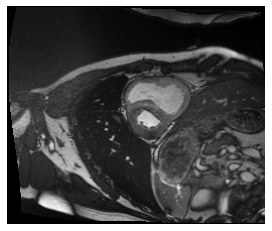

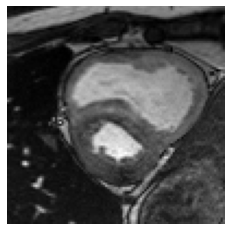

(100, 100, 30) 27.0 195.0


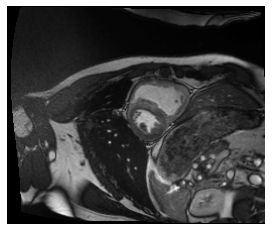

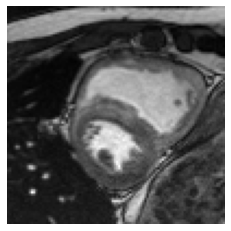

(100, 100, 30) 28.0 191.0


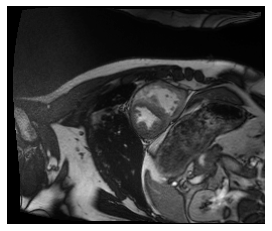

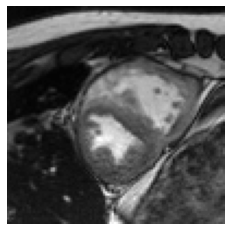

(100, 100, 30) 27.0 173.0


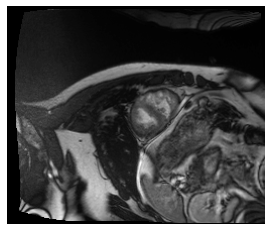

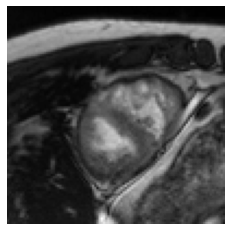

(100, 100, 30) 27.0 142.0


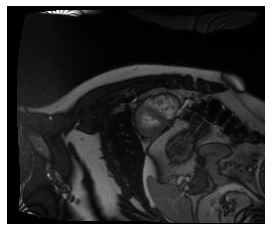

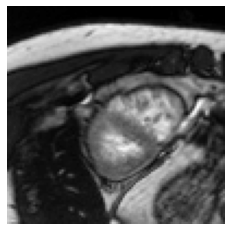

(100, 100, 30) 26.0 147.0


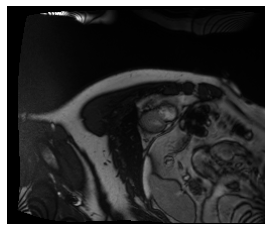

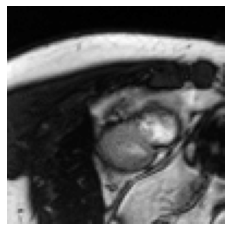

In [ ]:
#Create Val Data

img_no = 6
index =  [100,140] #26 [60,130] #22 [80,160]  #18[80,60]  #11, 19, 24 [80,140]    #10 [80,120]   
#7,20,21,23, 27 [90,130]   #3,6,17,25,28 [120,100]     #0-2, 4-5, 8- 10, 12-16, [100,130] 
print(val_list[img_no])
img_data_4d, affine_4d, header_4d = load_nii(val_list[img_no])
print(img_data_4d.shape)
save_path = "/content/drive/MyDrive/Cine Cardiac/val_data/"

for slice_no in range(img_data_4d.shape[-2]): 
  img_frames = img_data_4d[index[0]-50:index[0]+50,index[1]-50:index[1]+50,slice_no,:]
  print(img_frames.shape,img_frames.min(),img_frames.max())

  
  plt.figure()
  plt.imshow(img_data_4d[:,:,slice_no,14],cmap='gray')
  # plt.gca().add_patch(Rectangle((index[0]-50,index[1]-50),100,100,linewidth=1,edgecolor='r',facecolor='none'))
  plt.axis('off')
  plt.show()

  plt.figure()
  plt.imshow(img_frames[:,:,14],cmap='gray')
  plt.axis('off')
  plt.show()

  hf = h5py.File(save_path+f'val_{val_list[img_no][-13:-10]}_slice_{slice_no}.h5', 'w')
  hf.create_dataset('val', data = img_frames)
  hf.close()


In [ ]:
h5_file = "/content/drive/MyDrive/Cine Cardiac/val_data/val_097_slice_1.h5"

img_test = read_h5py(h5_file)
img_test = np.reshape(img_test,(100,100,1,30))
interactive_gif(img_test, cmap = 'gray')

Reading from /content/drive/MyDrive/Cine Cardiac/val_data/val_097_slice_1.h5 ====================================================
Keys in the h5py file : <KeysViewHDF5 ['val']>
Number of samples : 100
Shape of each data : (100, 100, 30)


interactive(children=(IntSlider(value=0, description='Select slice', max=0), Output()), _dom_classes=('widget-…

# Load Dataset Class

(240, 240, 30) 1.0


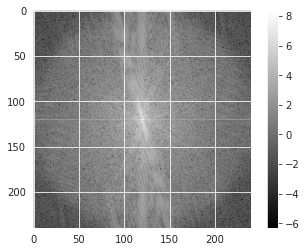

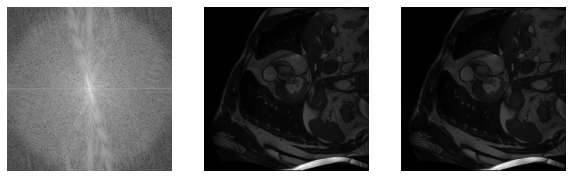

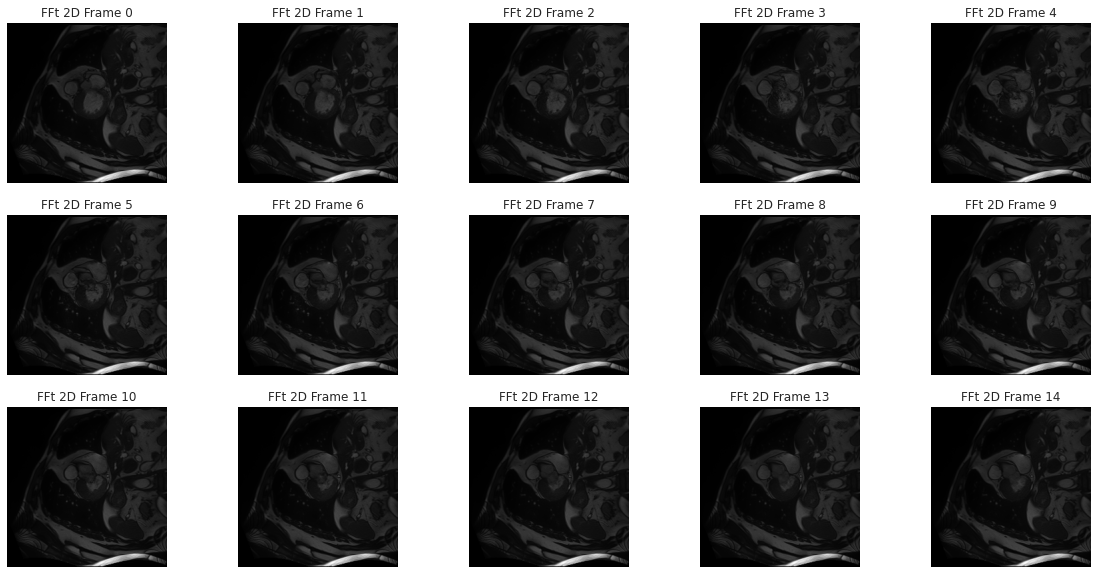

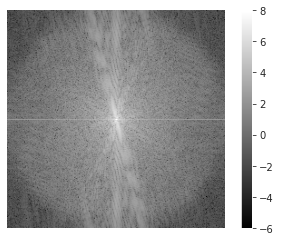

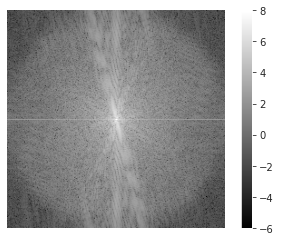

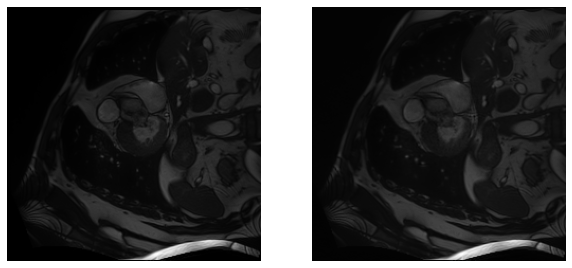

ValueError: ignored

In [202]:
img_data_4d, _,_ = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz")
img = img_data_4d[:,:240,0,:]
# img = read_h5py(val_data[14])
img = (img - np.min(img))/(np.max(img) - np.min(img))
print(img.shape, np.max(img))
N = 7
start_ind = N
end_ind = 30-N
motion_artefact_added = []
eps = 10e-9

def calculate_2dft(input):
    ft = np.fft.fft2(input)
    return np.fft.fftshift(ft)
def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    return ift.real

fft_2d = calculate_2dft(img[:,:,7])
plt.figure()
plt.imshow(np.log(np.abs(fft_2d)),cmap = 'gray')
plt.colorbar()


ifft_img = calculate_2dift(fft_2d)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(np.log(np.abs(fft_2d)),cmap = 'gray'), ax[0].axis('off')
ax[1].imshow(ifft_img,cmap = 'gray'), ax[1].axis('off')
ax[2].imshow(img[:,:,7],cmap = 'gray'), ax[2].axis('off')
plt.show()



for i in range(start_ind,end_ind):
  fft_mixed = calculate_2dft(img[:,:,i])#np.zeros(img[:,:,i].shape)
  fig, ax = plt.subplots(3,5, figsize=(20,10))
  for j in range(0,2*N+1): 
    fft_2d = calculate_2dft(img[:,:,(i+j)-N])
    fft_mixed[:,j*16:(j+1)*16] = fft_2d[:,j*16:(j+1)*16]

    # if j<N:
    #     fft_mixed[:,j*14:(j+1)*14] = fft_2d[:,j*14:(j+1)*14]
    # elif j == N:
    #   fft_mixed[:,j*14: 240-N*14] = fft_2d[:,j*14: 240-N*14]
    # elif j>N:
    #   fft_mixed[:,142+(j-N-1)*14: 142+(j-N)*14] = fft_2d[:,142+(j-N-1)*14: 142+(j-N)*14]

    # print(fft_2d.shape)
    ax[j//5][j%5].imshow(img[:,:,(i+j)-N], cmap='gray'), ax[j//5][j%5].set_title(f'FFt 2D Frame {j}'),ax[j//5][j%5].axis('off')
  # plt.show()

  plt.figure()
  plt.imshow(np.log(np.abs(fft_mixed)+eps),cmap = 'gray',vmax = 8, vmin = -6)
  plt.axis('off')
  plt.colorbar()
  plt.show()

  # fft_mixed[0:25,:] = 0
  # fft_mixed[-25:,:] = 0
  # fft_mixed[:,0:25] = 0
  # fft_mixed[:,-25:] = 0

  plt.figure()
  plt.imshow(np.log(np.abs(fft_mixed)+eps),cmap = 'gray',vmax = 8, vmin = -6)
  plt.axis('off')
  plt.colorbar()
  plt.show()

  ma_img = calculate_2dift(fft_mixed)

  fig, ax = plt.subplots(1,2, figsize=(10,10))
  ax[0].imshow(img[:,:,i],cmap = 'gray'), ax[0].axis('off')
  ax[1].imshow(ma_img,cmap = 'gray'), ax[1].axis('off')
  plt.show()

  motion_artefact_added.append(ma_img)
  break

motion_artefact_added = np.reshape(np.array(motion_artefact_added),(1,end_ind - start_ind,100,100))


interactive_gif_data(motion_artefact_added, cmap = 'gray')



# fig, ax = plt.subplots(3,10, figsize=(30,10))
# for i in range(30):
#   ax[i//10][i%10].imshow(img[:,:,i], cmap='gray'), ax[i//10][i%10].set_title(f'Frame {i}'),ax[i//10][i%10].axis('off')


In [218]:
def calculate_2dft(input):
    ft = np.fft.fft2(input)
    return np.fft.fftshift(ft)
def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    return ift.real

def add_motion_artefacts(img):
  N = 7
  start_ind = N
  end_ind = 30-N
  motion_artefact_added = []
  eps = 10e-11

  for i in range(start_ind,end_ind):
    fft_mixed = calculate_2dft(img[:,:,i])

    # K-space mixing
    for j in range(0,2*N+1): 
      fft_2d = calculate_2dft(img[:,:,(i+j)-N])
      if j<N:
        fft_mixed[:,j*6:(j+1)*6] = fft_2d[:,j*6:(j+1)*6]
      elif j == N:
        fft_mixed[:,j*6: 58] = fft_2d[:,j*6:58]
      elif j>N:
        fft_mixed[:,58+(j-N-1)*6: 58+(j-N)*6] = fft_2d[:,58+(j-N-1)*6: 58+(j-N)*6]

    # Zero Padding
    fft_mixed[0:25,:] = 0
    fft_mixed[-25:,:] = 0
    fft_mixed[:,0:25] = 0
    fft_mixed[:,-25:] = 0

    ma_img = calculate_2dift(fft_mixed)
    motion_artefact_added.append(ma_img)

  motion_artefact_added = np.array(motion_artefact_added)
  return motion_artefact_added

In [231]:
class CineCardiac(Dataset):
    def __init__(self, data_list, device,data_type = None,  transform=None, target_transform=None):
        
        first = True
        for base in data_list:
          if first:
            self.img_data = np.reshape(read_h5py(base),(1,100,100,30))
            first = False
          else:
            self.img_data = np.concatenate((self.img_data,np.reshape(read_h5py(base),(1,100,100,30))),axis = 0)

        print(self.img_data.shape)    
        self.device = device
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
      gt = (self.img_data[idx] - np.min(self.img_data[idx]))/(np.max(self.img_data[idx]) - np.min(self.img_data[idx])) #Normalizing to [0,1]
      img = add_motion_artefacts(gt)
      img = np.moveaxis(img,0,-1)
      gt = gt[:,:,7:23]
      # print(img.shape,gt.shape)
      if self.transform:
          img = self.transform(img).to(self.device)  
          gt  = self.transform(gt).to(self.device)  
      return img, gt

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [233]:
#Cine Cardiac MRI Dataset
train_data = glob("/content/drive/MyDrive/Cine Cardiac/train_data/train_*_slice_*.h5")
val_data = glob("/content/drive/MyDrive/Cine Cardiac/val_data/val_*_slice_*.h5")
print(train_data)
print(val_data)


# cine_train = CineCardiac(data_list = train_data, 
#                           device = device, 
#                           transform=transforms.Compose([
#                           transforms.ToTensor(),
#                           ])) 

cine_val = CineCardiac(data_list = val_data, 
                          device = device, data_type = 'Val', 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          ])) 
clear_output()

In [234]:
# Data loaders
# train_data_loader = data.DataLoader(cine_train, batch_size = 32, shuffle = True)
val_data_loader = data.DataLoader(cine_val, batch_size = 32, shuffle = False)

In [235]:
def interactive_gif_data(img, cmap = 'gray'):
  
  def Animate(slice):
    Figure = plt.figure() 
    # creating a plot
    imgs_plotted = plt.imshow(img[slice,0,:,:], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
        y = img[slice,frame,:,:]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[1]-1, interval=100)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    # plt.show()
  # good practice to close the plt object.
    plt.close()

  select_slice = IntSlider(min=0, max=img.shape[0]-1, description='Select slice', continuous_update=True)


  return interactive(Animate, slice=select_slice)


torch.Size([32, 16, 100, 100]) torch.Size([32, 16, 100, 100])


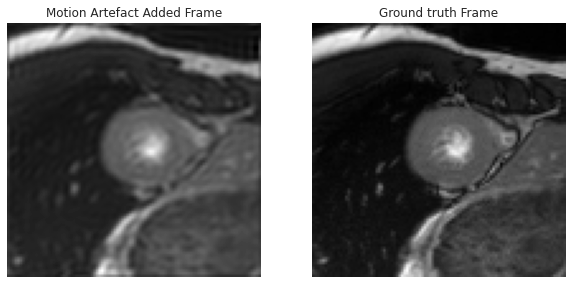

interactive(children=(IntSlider(value=0, description='Select slice', max=31), Output()), _dom_classes=('widget…

In [236]:
img, label   = next(iter(val_data_loader))
print(img.shape, label.shape)

ind = 14
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img[ind,0,:,:].cpu(), cmap='gray'), ax[0].set_title('Motion Artefact Added Frame'),ax[0].axis("off")
ax[1].imshow(label[ind,0,:,:].cpu(), cmap='gray'), ax[1].set_title('Ground truth Frame'),ax[1].axis("off")
plt.show()

interactive_gif_data(img, cmap = 'gray')


In [237]:
interactive_gif_data(label, cmap = 'gray')

interactive(children=(IntSlider(value=0, description='Select slice', max=31), Output()), _dom_classes=('widget…